<a href="https://colab.research.google.com/github/FrankAlvaradoR/Digital_Signal_Processing/blob/main/NLP_example1_part2_EDA_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
data=pd.read_pickle("/content/drive/My Drive/Colab_Notebooks/EjercicioNLP/transcripts/dtm.pkl")
data=data.transpose()
data.head()

In [ ]:
#Find the top 30 words said by each comedian 
top_dict={}
for c in data.columns:
  top = data[c].sort_values(ascending=False).head(30)
  top_dict[c]=list(zip(top.index, top.values))

top_dict

In [ ]:
#Print the top 15 words sais by each comedian 
for comedian, top_words in top_dict.items():
  print(comedian)
  print(', '.join([word for word, count in top_words[0:14]]))
  print(' - - -')



In [ ]:
#Look at the most common words --> add them to the stop words list
from collections import Counter 

#Let's first pull put the top 30 words for each comedian 
words=[]
for comedian in data.columns:
  top=[word for (word,count) in top_dict[comedian]]
  for t in top:
    words.append(t)
words

In [ ]:
Counter(words).most_common()

In [ ]:
add_stop_words = [word for word, count in Counter(words).most_common() if count >2]
add_stop_words

In [10]:
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer

#Read in cleaned data
data_clean = pd.read_pickle("/content/drive/My Drive/Colab_Notebooks/EjercicioNLP/transcripts/data_clean.pkl")

#Add new stop words
stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

#Recreate document text matrix
cv= CountVectorizer(stop_words=stop_words)
data_cv = cv.fit_transform(data_clean.transcript)
data_stop = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names_out())
data_stop.index = data_clean.index

#Pickle it for later use
import pickle
pickle.dump(cv, open("/content/drive/My Drive/Colab_Notebooks/EjercicioNLP/transcripts/cv_stop.pkl", "wb"))
data_stop.to_pickle("/content/drive/My Drive/Colab_Notebooks/EjercicioNLP/transcripts/dtm_stop.pkl")

In [12]:
#Lets make some clouds 
from wordcloud import WordCloud

wc = WordCloud(stopwords = stop_words, background_color="white",colormap="Dark2",max_font_size=150,random_state=42)

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize']=[16,6]

full_names = ['Bo Burnham','Dave Chappelle','Louis C.K.','Ricky']

for index, comedian in enumerate(data.columns):
  wc.generate(data_clean.transcript[comedian])

  plt.subplot(2,2,index+1)
  plt.imshow(wc, interpolation="bilinear")
  plt.axis("off")
  plt.title(full_names[index])

plt.show()

In [ ]:
#Number of works

#Find the numeber of unique words that each comedian uses
#Identify the non-zero items in the document-term matrix, meaning the words occurs at least 

unique_list=[]
for comedian in data.columns:
  uniques = data[comedian].to_numpy().nonzero()[0].size
  unique_list.append(uniques)

#Create a new data frame that contains this unique word count
data_words = pd.DataFrame(list(zip(full_names,unique_list)), columns=['comedian','unique_words'])
data_unique_sort = data_words.sort_values(by='unique_words')
data_unique_sort


In [ ]:
#Calculate the words per minute of each comedian
total_list= []
for comedian in data.columns:
  totals = sum(data[comedian])
  total_list.append(totals)

#Comedy special run times from IMDB in minutes
run_times = [ 60,67,58,79]

#Add some columns to our dataframe
data_words['total_words']=total_list
data_words['run_times'] = run_times
data_words['words_per_minute'] = data_words['total_words']/data_words['run_times']

#Sort the dataframe by words per minute to see who talks the slowest and fastest
data_wpm_sort = data_words.sort_values(by='words_per_minute')
data_wpm_sort


In [ ]:
#Let's plot our findings
import numpy as np

y_pos=np.arange(len(data_words))

plt.subplot(1,2,1)
plt.barh(y_pos, data_unique_sort.unique_words, align= 'center')
plt.yticks(y_pos, data_unique_sort.comedian)
plt.title('Number of unique words',fontsize=20)

plt.subplot(1,2,2)
plt.barh(y_pos, data_wpm_sort.words_per_minute, align='center')
plt.yticks(y_pos, data_wpm_sort.comedian)
plt.title('Number of words per minute', fontsize=20)

plt.tight_layout()
plt.show()

In [20]:
#Amount of profany
Counter(words).most_common()

#Isolate just these bad words
data_bad_words = data.transpose()[['fucking', 'fuck', 'shit']]
data_profany = pd.concat([data_bad_words.fucking + data_bad_words.fuck, data_bad_words.shit], axis=1, sort =False)
data_profany.columns = ['f_word','s_word']
data_profany

,f_word,s_word
bo,38,6
dave,65,46
louis,21,25
ricky,60,6


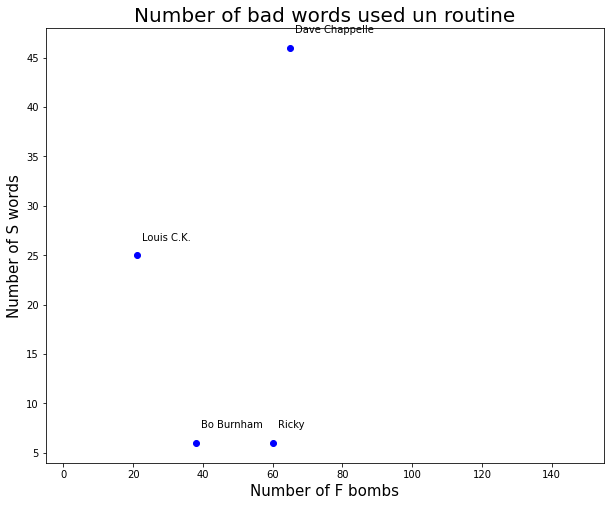

In [22]:
plt.rcParams['figure.figsize']=[10,8]
for i, comedian in enumerate(data_profany.index):
  x=data_profany.f_word.loc[comedian]
  y=data_profany.s_word.loc[comedian]
  plt.scatter(x,y,color='blue')
  plt.text(x+1.5,y+1.5,full_names[i], fontsize=10)
  plt.xlim(-5,155)

plt.title('Number of bad words used un routine',fontsize=20)
plt.xlabel('Number of F bombs',fontsize=15)
plt.ylabel('Number of S words',fontsize=15)

plt.show()